In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx
from isca_tools.thesis.lapse_theory import get_var_at_plev
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.decomposition import pca_on_xarray
from isca_tools.utils.ds_slicing import fold_coarsen
from isca_tools.utils.moist_physics import sphum_sat
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile, lcl_sigma_bolton_simple
from isca_tools.thesis.profile_fitting import get_mse_env, get_lnb_lev_ind, get_mse_prof_rms
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import wrap_with_apply_ufunc

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
from jobs.theory_lapse.scripts.lapse_fitting import processed_dir, processed_file_name, exp_name, quant_type

n_exp = len(exp_name)
quant = int(''.join(filter(str.isdigit, quant_type)))
temp_surf_lcl_calc = 300  # not actually used in lapse_fitting script - need to re-run using simple lapse fitting

In [5]:
# Load in data
ds = [xr.open_dataset(os.path.join(processed_dir[i], processed_file_name)) for i in range(n_exp)]
co2_vals = [get_co2_multiplier(i) for i in exp_name]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))
ds['rh_REFHT'] = ds['QREFHT'] / sphum_sat(ds.TREFHT, ds.PREFHT)

In [6]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
land_frac = xr.open_dataset(invariant_data_path).LANDFRAC
land_frac = land_frac.reindex_like(ds, method="nearest", tolerance=0.01)
land_frac_thresh = 0.9
lsm = (land_frac >= land_frac_thresh)

In [7]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30]),
                             bottom_labels=True, fontsize=None):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    if fontsize is not None:
        gl.xlabel_style = {'size': fontsize}
        gl.ylabel_style = {'size': fontsize}
    if not bottom_labels:
        gl.bottom_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

In [8]:
def get_var_av(var, n_lat_av=30, mask=None, av_dim=None):
    """Compute latitude-smoothed mean of a variable, ensuring no NaN latitudes.

    Args:
        var (xr.DataArray): Variable with dimensions ('lat', 'lon', 'sample', ...).
        n_lat_av (int, optional): Number of latitude points for rolling mean. Defaults to 30.
        mask (xr.DataArray, optional): Land-sea mask (True where valid). Defaults to None.

    Returns:
        xr.DataArray: Latitude-smoothed mean with all latitudes filled.
    """
    n_pad = n_lat_av // 2  # half-window size

    # Apply mask if provided
    if mask is not None:
        var = var.where(mask)

    # Take median over non-lat dims
    if av_dim is None:
        av_dim = [d for d in var.dims if d not in ['lat']]
    var_latmean = var.median(dim=av_dim)

    # Fill NaNs along latitude by nearest interpolation
    var_filled = var_latmean.interpolate_na(dim="lat", method="nearest", fill_value="extrapolate")

    # Pad with edge values to avoid NaNs at the ends
    var_padded = var_filled.pad(lat=(n_pad, n_pad), mode="edge")

    # Apply rolling mean and trim padding
    var_av = var_padded.rolling(lat=n_lat_av, center=True).mean().isel(lat=slice(n_pad, -n_pad))

    return var_av

## Temperature anomaly and change
Figure trying to explain, why hottest days in some regions more in current climate and change with warming differently

### % of Days convective
Below I plot the number of days for which the convective fitting works well.

In [10]:
temp_surf_lcl_calc = 300
ds['p_lcl'] = lcl_sigma_bolton_simple(ds.rh_REFHT, temp_surf_lcl_calc) * ds.PREFHT

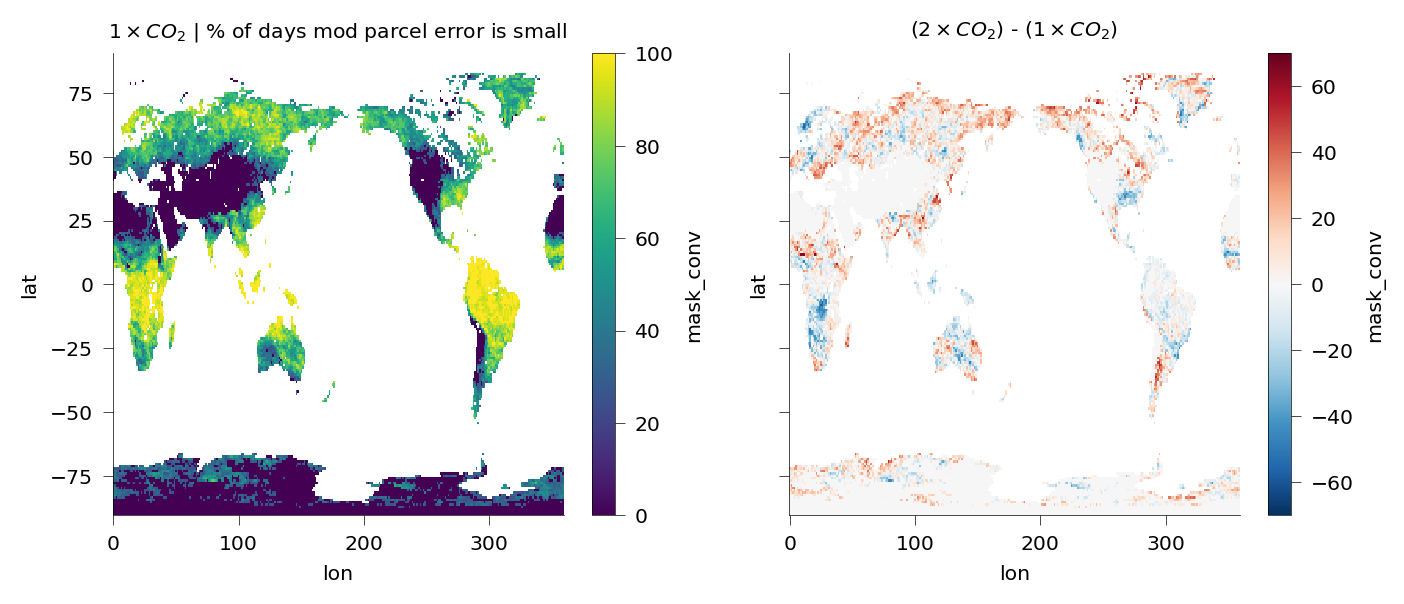

In [11]:
error_thresh = 0.25
error_thresh2 = 0.1
p_thresh = 900 * 100
p_lcl_thresh = float(ds.p_ft + 100*100)
use_p_lcl_thresh_method = True
const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
mod_parcel1_error = np.abs(ds.mod_parcel1_error.sum(dim='layer') / ds.mod_parcel1_integral.sum(dim='layer'))
mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh)
if use_p_lcl_thresh_method:
    ds['mask_conv'] = mask_fit & (ds.p_lcl > p_lcl_thresh) & lsm        # so range between LCL and p_ft
else:
    ds['mask_conv'] = mask_fit & (ds.PREFHT > p_thresh) & lsm
# Have mask for locations to use in final plotting so don't get big pressure swings with warming
ds['mask_conv_loc'] = ds['mask_conv'].sum(dim='sample').min(dim='co2') > 0.25 * ds.sample.size
ds['mask_conv'] = ds['mask_conv'].where(ds['mask_conv_loc'])

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 8)

var = (100 * ds['mask_conv'].sum(dim='sample') / ds.sample.size).where(lsm)
var.isel(co2=0).plot(ax=ax[0], vmin=0, vmax=100)
# im = plot_contour_projection(ax[0], var.isel(co2=0), levels=np.arange(0, 120, 20))
# plt.colorbar(im, ax=ax[0], label='Small-error days [%]', shrink=0.8)
ax[0].set_title(f"${int(ds.co2[0])} \\times CO_2$ | % of days mod parcel error is small")

(var.isel(co2=1) - var.isel(co2=0)).plot(ax=ax[1], vmin=-70)
ax[1].set_title(f"(${int(ds.co2[1])} \\times CO_2$) - (${int(ds.co2[0])} \\times CO_2$)")

fontsize_use = update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

## Coarsen Grid
Below, I coarsen grid, and then consider regions for which there are atleast 50 valid days at that new larger grid point.
There is still a significant number of regions to do subsequent analysis.

In [12]:
ds_sf = fold_coarsen(ds[['TREFHT', 'PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse', 'mask_conv']], 3, 6)
ds_sf['lapse_mod_D'] = ds_sf['mod_parcel1_lapse'].isel(layer=0) / 1000 - lapse_dry
ds_sf['lapse_mod_M'] = ds_sf['mod_parcel1_lapse'].isel(layer=1) / 1000
ds_sf = ds_sf.drop_vars(['mod_parcel1_lapse', 'layer'])
ds_sf = ds_sf.transpose('co2', 'sample', 'lon', 'lat')
ds_sf = ds_sf.rename({'TREFHT': 'temp_surf', 'PREFHT': 'p_surf', 'rh_REFHT': 'rh_surf', 'T_ft_env': 'temp_ft'})
mask_loc = ds_sf.mask_conv.sum(dim='sample').min(dim='co2') > 50
# mask_loc = ds_sf.mask_conv.sum(dim='sample').min(dim='co2') > 5

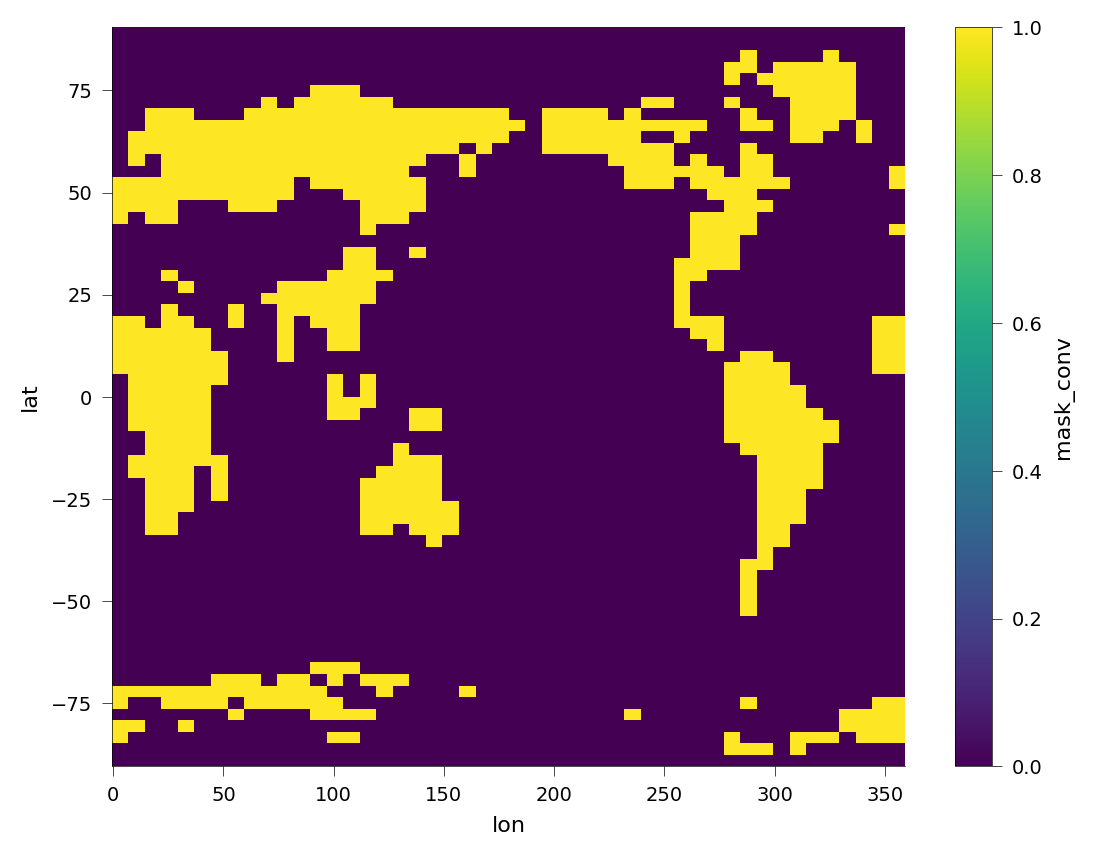

In [13]:
mask_loc.T.plot()

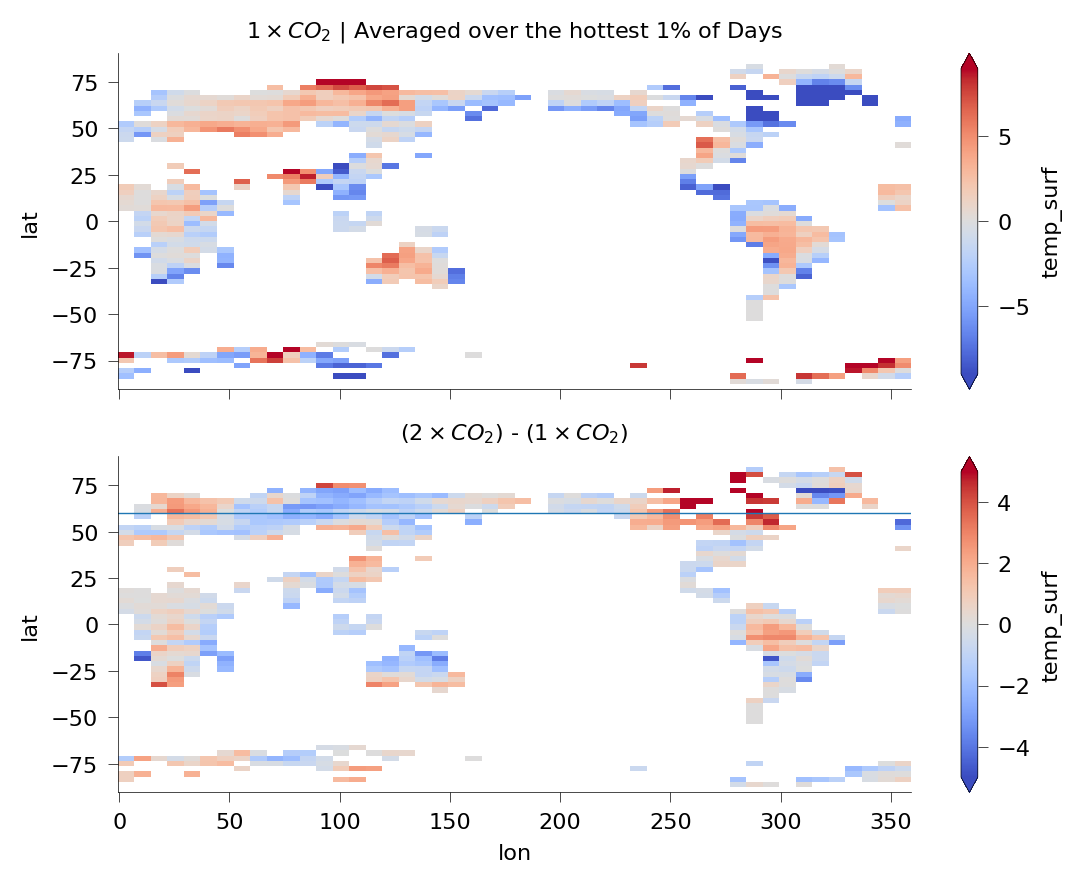

In [14]:
lat_min = -60
lat_max = 80
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
# ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})

var = ds_sf.temp_surf.where(ds_sf.mask_conv).median(dim='sample').where(mask_loc)
var = var - var.median(dim='lon')
# initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max, bottom_labels=False, fontsize=10.84)
var.T.isel(co2=0).plot(ax=ax[0], cmap='coolwarm', vmin=-9)
# im = plot_contour_projection(ax[0], var.isel(co2=0), cmap='coolwarm', levels=np.arange(-9, 10, 2))
# plt.colorbar(im, ax=ax[0], label='$T_s - \overline{T}_s$ [K]', shrink=0.8)
ax[0].set_title(f"${int(ds.co2[0])} \\times CO_2$ | Averaged over the hottest {100 - quant}% of Days")

# initialize_ax_projection(ax[1], lat_min=lat_min, lat_max=lat_max, fontsize=10.84)
(var.isel(co2=1) - var.isel(co2=0)).T.plot(ax=ax[1], cmap='coolwarm', vmin=-5)
# plt.colorbar(im, ax=ax[1], label='$\delta (T_s - \overline{T}_s)$ [K]', shrink=0.8)
ax[1].set_title(f"(${int(ds.co2[1])} \\times CO_2$) - (${int(ds.co2[0])} \\times CO_2$)")

fontsize_use = update_fontsize(fig, 5)
ax[1].axhline(60)
ax[0].set_xlabel('')
plt.show()

## Scale Factor at single latitude
Below, I plot what the scale factor breakdown looks like at a single latitude. I.e. why do hottest 1% of days at different longitudes warm at different rates?

In [15]:
def apply_scale_factor_spatial(ds, p_ft=float(ds.p_ft)):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical,
        ds["temp_surf_ref"],  # (co2)
        ds["temp_surf"],  # (co2, quant)
        ds["rh_surf_ref"],  # (co2)
        ds["rh_surf"],  # (co2, quant)
        ds["temp_ft"],  # (co2, quant)
        ds["lapse_mod_D"],  # (co2, quant)
        ds["lapse_mod_M"],  # (co2, quant)
        p_ft,  # (co2) or scalar
        ds["p_surf_ref"],  # (co2) or scalar
        ds["p_surf"],  # (co2, quant) or None
        ds["lapse_mod_D_ref"],  # (co2) or None
        ds["lapse_mod_M_ref"],  # (co2) or None
        kwargs=dict(
            temp_surf_lcl_calc=temp_surf_lcl_calc
        ),
        input_core_dims=[
            ["co2"],  # temp_surf_ref
            ["co2", "lon"],
            ["co2"],
            ["co2", "lon"],
            ["co2", "lon"],
            ["co2", "lon"],
            ["co2", "lon"],
            [],  # p_ft_ref
            ["co2"],  # p_surf_ref
            ["co2", "lon"],
            ["co2"],
            ["co2"],
        ],
        output_core_dims=[
            ["lon"],  # result array
            ["lon"],
            []  # dict-of-arrays (broadcast to co2)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, object],
    )
    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds['temp_surf'].isel(co2=1) - ds['temp_surf'].isel(co2=0)
                                ) / (ds['temp_surf_ref'].isel(co2=1) - ds['temp_surf_ref'].isel(co2=0))}

    # Determine all dict keys from the first element
    dict_single_lat = out_dict.isel(lat=0).item()
    keys = list(dict_single_lat.keys())

    for key in keys:
        # Collect arrays across lat dimension
        stacked = []
        for i in range(out_dict.sizes["lat"]):
            arr = out_dict.isel(lat=i).item()[key]  # (quant,)
            stacked.append(arr)

        da = xr.DataArray(
            np.stack(stacked, axis=0),  # (lat, quant)
            dims=("lat", "lon"),
            coords={"lat": ds.lat, "lon": ds.lon},
        )
        dict_ds[key] = da

    ds_out = xr.Dataset({"scale_factor_sum": out_main, "scale_factor_linear": out_linear, **dict_ds})
    ds_out = ds_out.transpose("lat", "lon")
    # ds_out = ds_out
    return ds_out

In [16]:
lat_use = 60
# lat_use = 62
lat_use = -5
# lat_use = 25
rh_ref = ds_sf['rh_surf'].where(ds_sf.mask_conv).where(mask_loc).sel(lat=[lat_use], method='nearest').median(
    dim=['sample', 'lon'])
ds_sl_all = ds_sf.where(ds_sf.mask_conv).where(mask_loc).sel(lat=[lat_use], method='nearest')
ds_sl = ds_sl_all.median(dim='sample')
# ds_sl = ds_sl_all.where(ds_sl_all.rh_surf<rh_ref).median(dim='sample')
# lapse_mod_D_thresh = ds_sl_all.lapse_mod_D.median(dim=['sample', 'co2'])
# ds_sl = ds_sl_all.where(ds_sl_all.lapse_mod_D>lapse_mod_D_thresh).median(dim='sample')
# ds_sl = ds_sl.where(ds_sl.temp_surf>0, drop=True)       # get rid of nan longitudes
for key in ['temp_surf', 'p_surf', 'rh_surf', 'lapse_mod_D', 'lapse_mod_M']:
    ds_sl[key + '_ref'] = ds_sf[key].where(ds_sf.mask_conv).where(mask_loc).sel(lat=[lat_use], method='nearest').median(
        dim=['sample', 'lon'])
    # ds_sl[key + '_ref'] = ds_sf[key].where(ds_sf.mask_conv).where(mask_loc).sel(lat=[lat_use], method='nearest').where(ds_sl_all.rh_surf<rh_ref).median(
    #     dim=['sample', 'lon'])
    # ds_sl[key + '_ref'] = ds_sf[key].where(ds_sf.mask_conv).where(mask_loc).sel(
    #     lat=[lat_use], method='nearest').where(ds_sl_all.lapse_mod_D>lapse_mod_D_thresh).median(dim=['sample', 'lon'])
    # if 'lapse' in key:
    #     ds_sl[key + '_ref'] = np.abs(ds_sl[key + '_ref'] * 0)  # for lapse, ref value is 0
    if key != 'temp_surf':
        # For rh and pressure, keep at colder climate ref
        ds_sl[key + '_ref'] = ds_sl[key + '_ref'] * 0 + ds_sl[key + '_ref'].isel(co2=0)
# ds_sl['rh_surf_ref'] = ds_sl['rh_surf_ref'] + 0.4                  # useful for East Canada, where one region has completely different humidity
get_temp_mod_parcel_xr = wrap_with_apply_ufunc(get_temp_mod_parcel)  # make function work with xarray
ds_sl['temp_ft_ref'] = get_temp_mod_parcel_xr(ds_sl['rh_surf_ref'], ds_sl['p_surf_ref'], float(ds.p_ft),
                                              ds_sl['lapse_mod_D_ref'],
                                              ds_sl['lapse_mod_M_ref'], ds_sl['temp_surf_ref'],
                                              temp_surf_lcl_calc=temp_surf_lcl_calc)
ds_sl['scale_factor'] = (ds_sl['temp_surf'].isel(co2=1) - ds_sl['temp_surf'].isel(co2=0)
                         ) / (ds_sl['temp_surf_ref'].isel(co2=1) - ds_sl['temp_surf_ref'].isel(co2=0))

### Sum of change mechanisms
Below I do a simple estimate of the scale factor, keeping all but one variable at the reference values; with the other set to the actual value.
I then sum up the individual contributions to give the final value.

This does not give any information on sensitivity within the current climate however.

In [17]:
sf_cont = {}
# sf_cont['temp_ft'] = ds_sl.temp_surf - get_temp_mod_parcel_xr(ds_sl['rh_surf'], ds_sl['p_surf'], float(ds.p_ft),
#                                                               ds_sl['lapse_mod_D'], ds_sl['lapse_mod_M'],
#                                                               None, ds_sl['temp_ft_ref'], temp_surf_lcl_calc=temp_surf_lcl_calc)
# sf_cont['lapse_mod_M'] = ds_sl.temp_surf - get_temp_mod_parcel_xr(ds_sl['rh_surf'], ds_sl['p_surf'], float(ds.p_ft),
#                                                               ds_sl['lapse_mod_D'], ds_sl['lapse_mod_M_ref'],
#                                                               None, ds_sl['temp_ft'], temp_surf_lcl_calc=temp_surf_lcl_calc)
# sf_cont['lapse_mod_D'] = ds_sl.temp_surf - get_temp_mod_parcel_xr(ds_sl['rh_surf'], ds_sl['p_surf'], float(ds.p_ft),
#                                                               ds_sl['lapse_mod_D_ref'], ds_sl['lapse_mod_M'],
#                                                               None, ds_sl['temp_ft'], temp_surf_lcl_calc=temp_surf_lcl_calc)
# sf_cont['p_surf'] = ds_sl.temp_surf - get_temp_mod_parcel_xr(ds_sl['rh_surf'], ds_sl['p_surf_ref'], float(ds.p_ft),
#                                                               ds_sl['lapse_mod_D'], ds_sl['lapse_mod_M'],
#                                                               None, ds_sl['temp_ft'], temp_surf_lcl_calc=temp_surf_lcl_calc)
# sf_cont['rh_surf'] = ds_sl.temp_surf - get_temp_mod_parcel_xr(ds_sl['rh_surf_ref'], ds_sl['p_surf'], float(ds.p_ft),
#                                                               ds_sl['lapse_mod_D'], ds_sl['lapse_mod_M'],
#                                                               None, ds_sl['temp_ft'], temp_surf_lcl_calc=temp_surf_lcl_calc)

sf_cont['temp_ft'] = get_temp_mod_parcel_xr(ds_sl['rh_surf_ref'], ds_sl['p_surf_ref'], float(ds.p_ft),
                                            ds_sl['lapse_mod_D_ref'], ds_sl['lapse_mod_M_ref'],
                                            None, ds_sl['temp_ft'], temp_surf_lcl_calc=temp_surf_lcl_calc) - ds_sl[
                         'temp_surf_ref']
sf_cont['lapse_mod_M'] = get_temp_mod_parcel_xr(ds_sl['rh_surf_ref'], ds_sl['p_surf_ref'], float(ds.p_ft),
                                                ds_sl['lapse_mod_D_ref'], ds_sl['lapse_mod_M'],
                                                None, ds_sl['temp_ft_ref'], temp_surf_lcl_calc=temp_surf_lcl_calc) - \
                         ds_sl['temp_surf_ref']
sf_cont['lapse_mod_D'] = get_temp_mod_parcel_xr(ds_sl['rh_surf_ref'], ds_sl['p_surf_ref'], float(ds.p_ft),
                                                ds_sl['lapse_mod_D'], ds_sl['lapse_mod_M_ref'],
                                                None, ds_sl['temp_ft_ref'], temp_surf_lcl_calc=temp_surf_lcl_calc) - \
                         ds_sl['temp_surf_ref']
sf_cont['p_surf'] = get_temp_mod_parcel_xr(ds_sl['rh_surf_ref'], ds_sl['p_surf'], float(ds.p_ft),
                                           ds_sl['lapse_mod_D_ref'], ds_sl['lapse_mod_M_ref'],
                                           None, ds_sl['temp_ft_ref'], temp_surf_lcl_calc=temp_surf_lcl_calc) - ds_sl[
                        'temp_surf_ref']
sf_cont['rh_surf'] = get_temp_mod_parcel_xr(ds_sl['rh_surf'], ds_sl['p_surf_ref'], float(ds.p_ft),
                                            ds_sl['lapse_mod_D_ref'], ds_sl['lapse_mod_M_ref'],
                                            None, ds_sl['temp_ft_ref'], temp_surf_lcl_calc=temp_surf_lcl_calc) - ds_sl[
                         'temp_surf_ref']

sf_cont['sum'] = None
for key in sf_cont:
    if key == 'sum':
        continue
    sf_cont[key] = (sf_cont[key].isel(co2=1) - sf_cont[key].isel(co2=0)) / (
            ds_sl['temp_surf_ref'].isel(co2=1) - ds_sl['temp_surf_ref'].isel(co2=0))
    sf_cont[key] = sf_cont[key].isel(lat=0)
    if sf_cont['sum'] is None:
        sf_cont['sum'] = sf_cont[key]
    else:
        sf_cont['sum'] = sf_cont['sum'] + sf_cont[key]

In [18]:
style_map = {
    # --- reference change (dashed) ---
    "r_ref_change": ("C0", "--"),
    "p_surf_ref_change": ("C4", "--"),
    "lapse_mod_D_ref_change": ("C1", "--"),
    "lapse_mod_M_ref_change": ("C3", "--"),

    # --- change (solid) ---
    "temp_ft_change": ("C2", "-"),
    "r_change": ("C0", "-"),
    "rh_surf_change": ("C0", "-"),
    "lapse_mod_D_change": ("C1", "-"),
    "lapse_mod_M_change": ("C3", "-"),
    "p_surf_change": ("C4", "-"),
    "error_av_change": ("C5", "-"),

    # --- anomalies (dotted) ---
    "temp_anom": ("C2", ":"),
    "r_anom": ("C0", ":"),
    "lapse_mod_D_anom": ("C1", ":"),
    "lapse_mod_M_anom": ("C3", ":"),
    "p_surf_anom": ("C4", ":"),

    # nl
    "nl_residual": ("C5", "-."),

    # sf
    "scale_factor": ('k', "-"),
    "scale_factor_linear": ('k', ":"),
    "scale_factor_sum": ('k', "--")
}

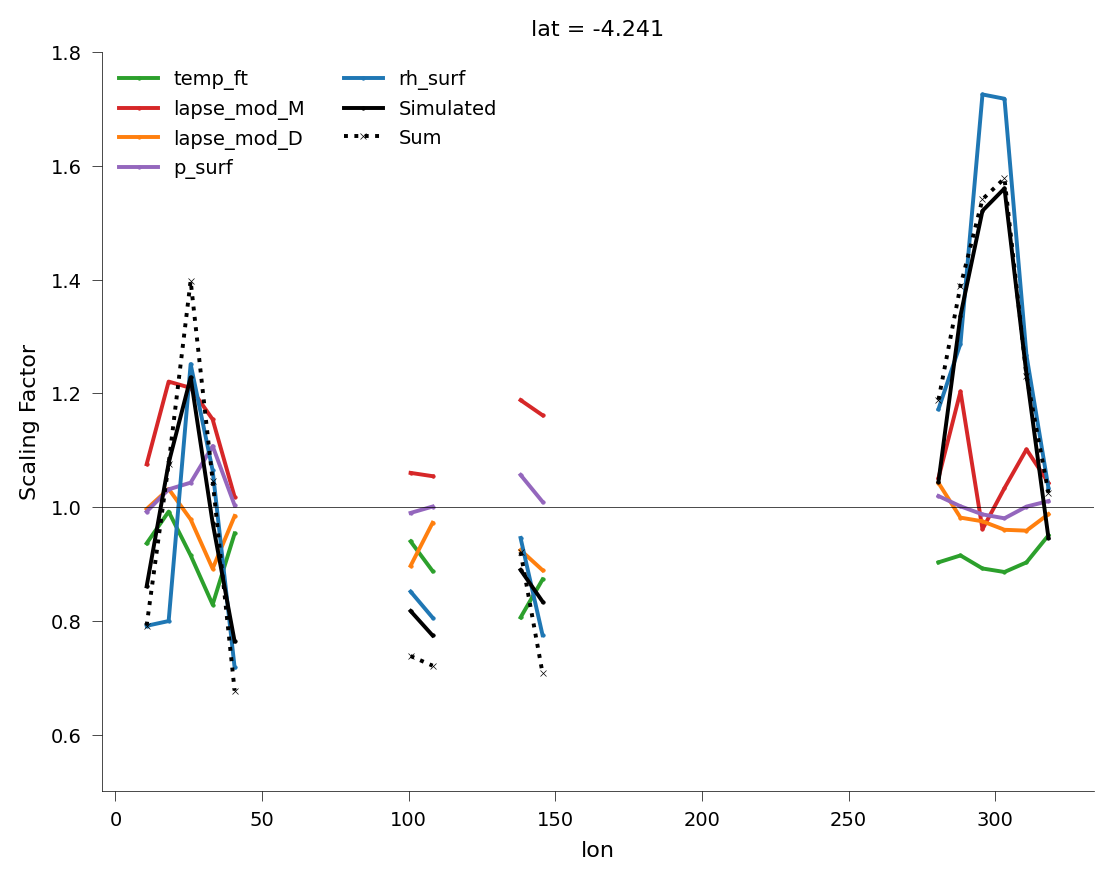

In [19]:
fig, ax = plt.subplots(1, 1)
for key in sf_cont:
    if key == 'sum':
        continue
    (sf_cont[key] + 1).plot(label=key, color=style_map[key + '_change'][0], linestyle=style_map[key + '_change'][1],
                            marker='.')
ds_sl['scale_factor'].plot(ax=ax, color='k', label='Simulated', marker='.')
(sf_cont['sum'] + 1).plot(ax=ax, color='k', linestyle=':', label='Sum', marker='x')
update_linewidth(fig, 0.7)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.legend(ncol=2)
ax.set_ylabel('Scaling Factor')
ax.set_ylim(0, 3)
ax.set_ylim(0.5, 1.8)
plt.show()

### Include climatological mechanisms
Below, I include the climatological mechanisms in the breakdown. It is not as good an approximation.

In [20]:
ds_out = apply_scale_factor_spatial(ds_sl).isel(lat=0)

In [21]:
style_map = {
    # --- reference change (dashed) ---
    "r_ref_change": ("C0", "--"),
    "p_surf_ref_change": ("C4", "--"),
    "lapse_mod_D_ref_change": ("C1", "--"),
    "lapse_mod_M_ref_change": ("C3", "--"),

    # --- change (solid) ---
    "temp_ft_change": ("C2", "-"),
    "r_change": ("C0", "-"),
    "lapse_mod_D_change": ("C1", "-"),
    "lapse_mod_M_change": ("C3", "-"),
    "p_surf_change": ("C4", "-"),
    "error_av_change": ("C5", "-"),

    # --- anomalies (dotted) ---
    "temp_anom": ("C2", ":"),
    "r_anom": ("C0", ":"),
    "lapse_mod_D_anom": ("C1", ":"),
    "lapse_mod_M_anom": ("C3", ":"),
    "p_surf_anom": ("C4", ":"),

    # nl
    "nl_residual": ("C5", "-."),

    # sf
    "scale_factor": ('k', "-"),
    "scale_factor_linear": ('k', ":"),
    "scale_factor_sum": ('k', "--")
}
for key2 in [k for k in style_map if "nl" not in k and "ref" not in k]:
    style_map['nl_' + key2] = (style_map[key2][0], '-.')

labels_var = {'r': '$r_s$', 'p_surf': '$p_s$', 'temp_ft': '$T_{FT}$', 'temp': '$T_s$',
              'lapse_mod_D': '$\eta_D$', 'lapse_mod_M': '$\eta_M$',
              'anom': '$\Delta$', 'change': '$\delta$', 'error_av': 'error_av'}

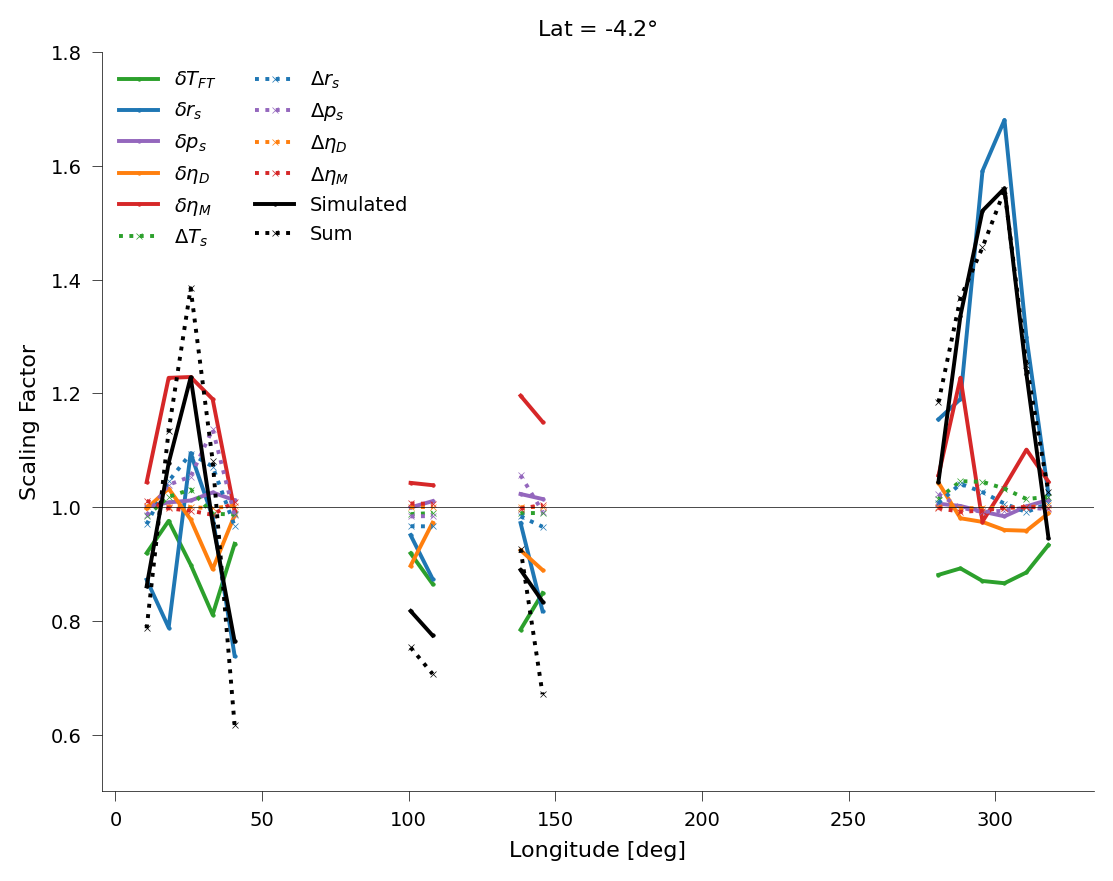

In [22]:
show_non_linear = False
fig, ax = plt.subplots(1, 1)
for key in ds_out:
    var = ds_out[key]
    if ('scale_factor' in key) or ('nl' in key) or ('error' in key) or ('ref' in key):
        continue
    # elif 'nl' in key:
    #     # Combine non-linear and linear into single mechanism on plot
    #     if (not show_non_linear) and ('residual' not in key):
    #         var = var + ds_out[key.replace('nl_', '')] - 1
    #         key = key.replace('nl_', '')
    # elif (not show_non_linear) and ('error_av' not in key):
    #     continue
    # if np.abs(var - 1).max() < 0.1:
    #     continue
    label_use = ''
    if 'anom' in key:
        label_use = label_use + labels_var['anom'] + labels_var[key.replace('_anom', '')]
    elif 'change' in key:
        label_use = label_use + labels_var['change'] + labels_var[key.replace('_change', '')]
    ax.plot(ds_out.lon, var, label=label_use,
            color=style_map[key][0], linestyle=style_map[key][1], marker='.' if 'change' in key else 'x')
for i, key in enumerate(['scale_factor', 'scale_factor_linear']):
    ax.plot(ds_out.lon, ds_out[key],
            color=style_map[key][0], linestyle=style_map[key][1], label=['Simulated', 'Sum'][i], marker=['.', 'x'][i])
update_linewidth(fig, 0.7)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.legend(ncol=2)
ax.set_ylabel('Scaling Factor')
ax.set_xlabel('Longitude [deg]')
ax.set_title(f"Lat = {ds_sl['lat'][0]:.1f}$\degree$")
ax.set_ylim(0.5, 1.8)
plt.show()

### Single Latitude and longitude Scatter


In [23]:
lon_use = 295
lon_use = 318
lon_use = 265
lon_use = 288
# lon_use = float(ds_out.lon.isel(lon=ds_out.scale_factor.argmax()))
# lon_use = 280
# lon_use = 0
# n_var = len(ds_pca.data_vars)
# Unique values for coloring/markers

# Assign colors and markers
# colors = plt.cm.viridis(np.linspace(0, 1, len(ds_pca.lat)))
# markers = ['.', 'x']  # extend if needed
var_list = ['temp_ft', 'p_surf', 'rh_surf', 'lapse_mod_D', 'lapse_mod_M']
fig, axes = plt.subplots(len(var_list), len(var_list), squeeze=False)
fig_resize(fig, 12)
for i, var_y in enumerate(var_list):
    for j, var_x in enumerate(var_list):
        ax = axes[i, j]
        for co2idx, tau in enumerate(ds_sl_all.co2):
            # Filter data for specific latitude and co2
            x = ds_sl_all[var_x].sel(lon=lon_use, co2=tau, method='nearest') - ds_sl[var_x + '_ref'].isel(co2=co2idx)
            y = ds_sl_all[var_y].sel(lon=lon_use, co2=tau, method='nearest') - ds_sl[var_y + '_ref'].isel(co2=co2idx)
            # x = ds_sl_all[var_x].where(ds_sl_all['lapse_mod_D']>lapse_mod_D_thresh).sel(lon=lon_use, co2=tau, method='nearest') - ds_sl[var_x + '_ref'].isel(co2=co2idx)
            # y = ds_sl_all[var_y].where(ds_sl_all['lapse_mod_D']>lapse_mod_D_thresh).sel(lon=lon_use, co2=tau, method='nearest') - ds_sl[var_y + '_ref'].isel(co2=co2idx)
            if i == j:
                # Diagonal: histogram line
                ax.hist(x.values.flatten(), bins=30, color=f"C{co2idx}",
                        histtype='step', linewidth=1.5)
            else:
                ax.scatter(x, y, color=f"C{co2idx}", marker='.', s=1)
                ax.scatter(
                    ds_sl[var_x].sel(lon=lon_use, co2=tau, method='nearest') - ds_sl[var_x + '_ref'].isel(co2=co2idx),
                    ds_sl[var_y].sel(lon=lon_use, co2=tau, method='nearest') - ds_sl[var_y + '_ref'].isel(co2=co2idx),
                    color=f"C{co2idx}", marker='x', s=40, lw=3)
                # ax.axhline(0, color='k', lw=ax_linewidth)
                # ax.axvline(0, color='k', lw=ax_linewidth)

        if i == len(var_list) - 1:
            ax.set_xlabel(var_x)
        if j == 0:
            ax.set_ylabel(var_y)
        # ax.grid(True)

# Optional: create a single legend
handles, labels = axes[0, 1].get_legend_handles_labels()
# fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center')
fig.suptitle(f"Lat = {ds_sl['lat'][0]:.1f}$\degree$ | Lon = {lon_use:.1f}$\degree$")
plt.tight_layout()
# plt.show()
plt.close()

## Spatial Map
Below I compute the two estimates of the scaling factor at every location, relative to a spatial average. I then decompose this into the physical mechanisms.

Scale factor is the change in temperature, where the temperature is averaged over the following days at each location:
* Take hottest 1% of days at coordinate
* Get rid of coordinate if less land_frac than 0.9
* Get rid of samples for which conv error < 25% and less than `const_lapse`
* Get rid if p_lcl < 500hPa
* Coarsen the resultant grid
* Get rid of the resultant coarsened location if less than 50 days at that location

In [39]:
ds_use = ds_sf.where(ds_sf.mask_conv).where(mask_loc).median(dim='sample').sel(lat=slice(-60, 80))

for key in ['temp_surf', 'p_surf', 'rh_surf', 'lapse_mod_D', 'lapse_mod_M']:
    # ds_use[key + '_ref'] = ds_use[key].median(dim='lon')
    ds_use[key + '_ref'] = get_var_av(ds_use[key], av_dim='lon')        # looks better with this ref in spatial plot - much smoother
    if key != 'temp_surf':
        # For rh and pressure, keep at colder climate ref
        ds_use[key + '_ref'] = ds_use[key + '_ref'] * 0 + ds_use[key + '_ref'].isel(co2=0)
# ds_sl['rh_surf_ref'] = ds_sl['rh_surf_ref'] + 0.4                  # useful for East Canada, where one region has completely different humidity
ds_use['temp_ft_ref'] = get_temp_mod_parcel_xr(ds_use['rh_surf_ref'], ds_use['p_surf_ref'], float(ds.p_ft),
                                               ds_use['lapse_mod_D_ref'],
                                               ds_use['lapse_mod_M_ref'], ds_use['temp_surf_ref'],
                                               temp_surf_lcl_calc=temp_surf_lcl_calc)
ds_use['scale_factor'] = (ds_use['temp_surf'].isel(co2=1) - ds_use['temp_surf'].isel(co2=0)
                          ) / (ds_use['temp_surf_ref'].isel(co2=1) - ds_use['temp_surf_ref'].isel(co2=0))

In [40]:
sf_cont = {}
with tqdm(total=5, desc="sf_cont mechanisms", leave=True) as pbar:
    sf_cont['temp_ft'] = get_temp_mod_parcel_xr(ds_use['rh_surf_ref'], ds_use['p_surf_ref'], float(ds.p_ft),
                                                        ds_use['lapse_mod_D_ref'], ds_use['lapse_mod_M_ref'],
                                                        None, ds_use['temp_ft'],
                                                        temp_surf_lcl_calc=temp_surf_lcl_calc) - ds_use['temp_surf_ref']
    pbar.update(1)

    sf_cont['lapse_mod_M'] = get_temp_mod_parcel_xr(ds_use['rh_surf_ref'], ds_use['p_surf_ref'], float(ds.p_ft),
                                                    ds_use['lapse_mod_D_ref'], ds_use['lapse_mod_M'],
                                                    None, ds_use['temp_ft_ref'],
                                                    temp_surf_lcl_calc=temp_surf_lcl_calc) - ds_use['temp_surf_ref']
    pbar.update(1)

    sf_cont['lapse_mod_D'] = get_temp_mod_parcel_xr(ds_use['rh_surf_ref'], ds_use['p_surf_ref'], float(ds.p_ft),
                                                    ds_use['lapse_mod_D'], ds_use['lapse_mod_M_ref'],
                                                    None, ds_use['temp_ft_ref'],
                                                    temp_surf_lcl_calc=temp_surf_lcl_calc) - ds_use['temp_surf_ref']
    pbar.update(1)

    sf_cont['p_surf'] = get_temp_mod_parcel_xr(ds_use['rh_surf_ref'], ds_use['p_surf'], float(ds.p_ft),
                                               ds_use['lapse_mod_D_ref'], ds_use['lapse_mod_M_ref'],
                                               None, ds_use['temp_ft_ref'],
                                               temp_surf_lcl_calc=temp_surf_lcl_calc) - ds_use['temp_surf_ref']
    pbar.update(1)

    sf_cont['rh_surf'] = get_temp_mod_parcel_xr(ds_use['rh_surf'], ds_use['p_surf_ref'], float(ds.p_ft),
                                                ds_use['lapse_mod_D_ref'], ds_use['lapse_mod_M_ref'],
                                                None, ds_use['temp_ft_ref'],
                                                temp_surf_lcl_calc=temp_surf_lcl_calc) - ds_use['temp_surf_ref']
    pbar.update(1)

sf_cont['sum'] = None
for key in sf_cont:
    if key == 'sum':
        continue
    sf_cont[key] = (sf_cont[key].isel(co2=1) - sf_cont[key].isel(co2=0)) / (
            ds_use['temp_surf_ref'].isel(co2=1) - ds_use['temp_surf_ref'].isel(co2=0))
    sf_cont[key] = sf_cont[key].transpose('lat', 'lon')
    if sf_cont['sum'] is None:
        sf_cont['sum'] = sf_cont[key]
    else:
        sf_cont['sum'] = sf_cont['sum'] + sf_cont[key]

sf_cont mechanisms:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
ds_use_sf = apply_scale_factor_spatial(ds_use)

### Scale Factor Estimates
Below, get a pretty good estimate from both methods.

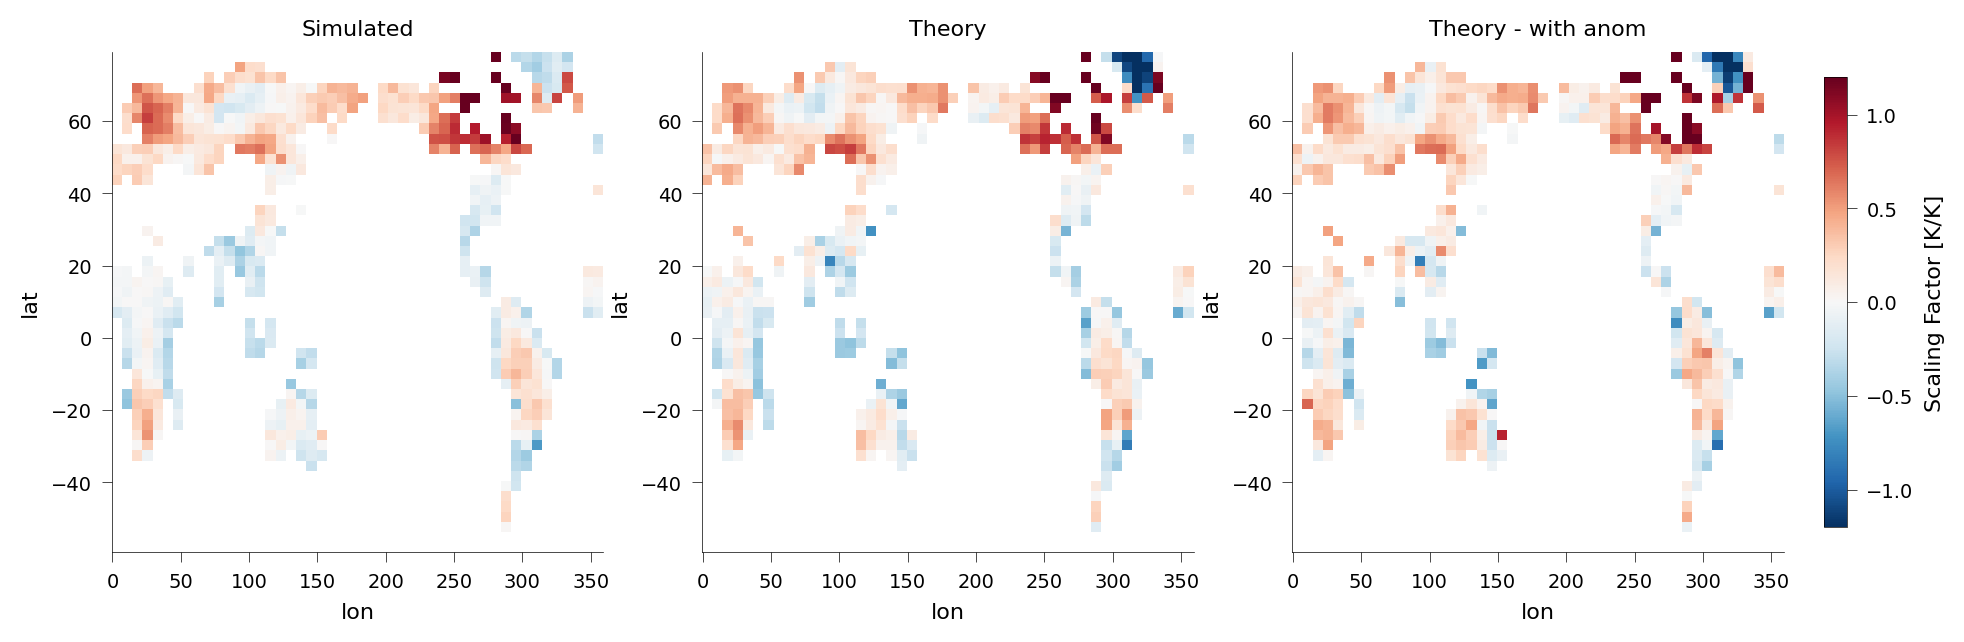

In [60]:
fig, ax = plt.subplots(1, 3)
fig_resize(fig, 13)
# for key in sf_cont:
#     if key == 'sum':
#         continue
#     (sf_cont[key] + 1).plot(label=key, color=style_map[key + '_change'][0], linestyle=style_map[key + '_change'][1],
#                             marker='.')

vmin_sf = -1.2
cmap = plt.rcParams.get('image.cmap', 'viridis')

im0 = (ds_use['scale_factor'].T - 1).plot(ax=ax[0], vmin=vmin_sf, add_colorbar=False)
ax[0].set_title('Simulated')
(sf_cont['sum']).plot(ax=ax[1], vmin=vmin_sf, add_colorbar=False)
ax[1].set_title('Theory')
(ds_use_sf.scale_factor_linear - 1).plot(ax=ax[2], vmin=vmin_sf, add_colorbar=False)
ax[2].set_title('Theory - with anom')

cbar = fig.colorbar(im0, ax=ax, orientation='vertical', shrink=0.9, pad=0.02)
cbar.set_label('Scaling Factor [K/K]')

# update_linewidth(fig, 0.7)
# ax.axhline(1, color='k', lw=ax_linewidth)
# ax.legend(ncol=2)
# ax.set_ylabel('Scaling Factor')
# ax.set_ylim(0, 3)
# ax.set_ylim(0.5, 1.8)
plt.show()


### Physical mechanisms 1
Below is breakdown into physical mechanisms, combining the anom and change mechanisms into one mechanism for each.

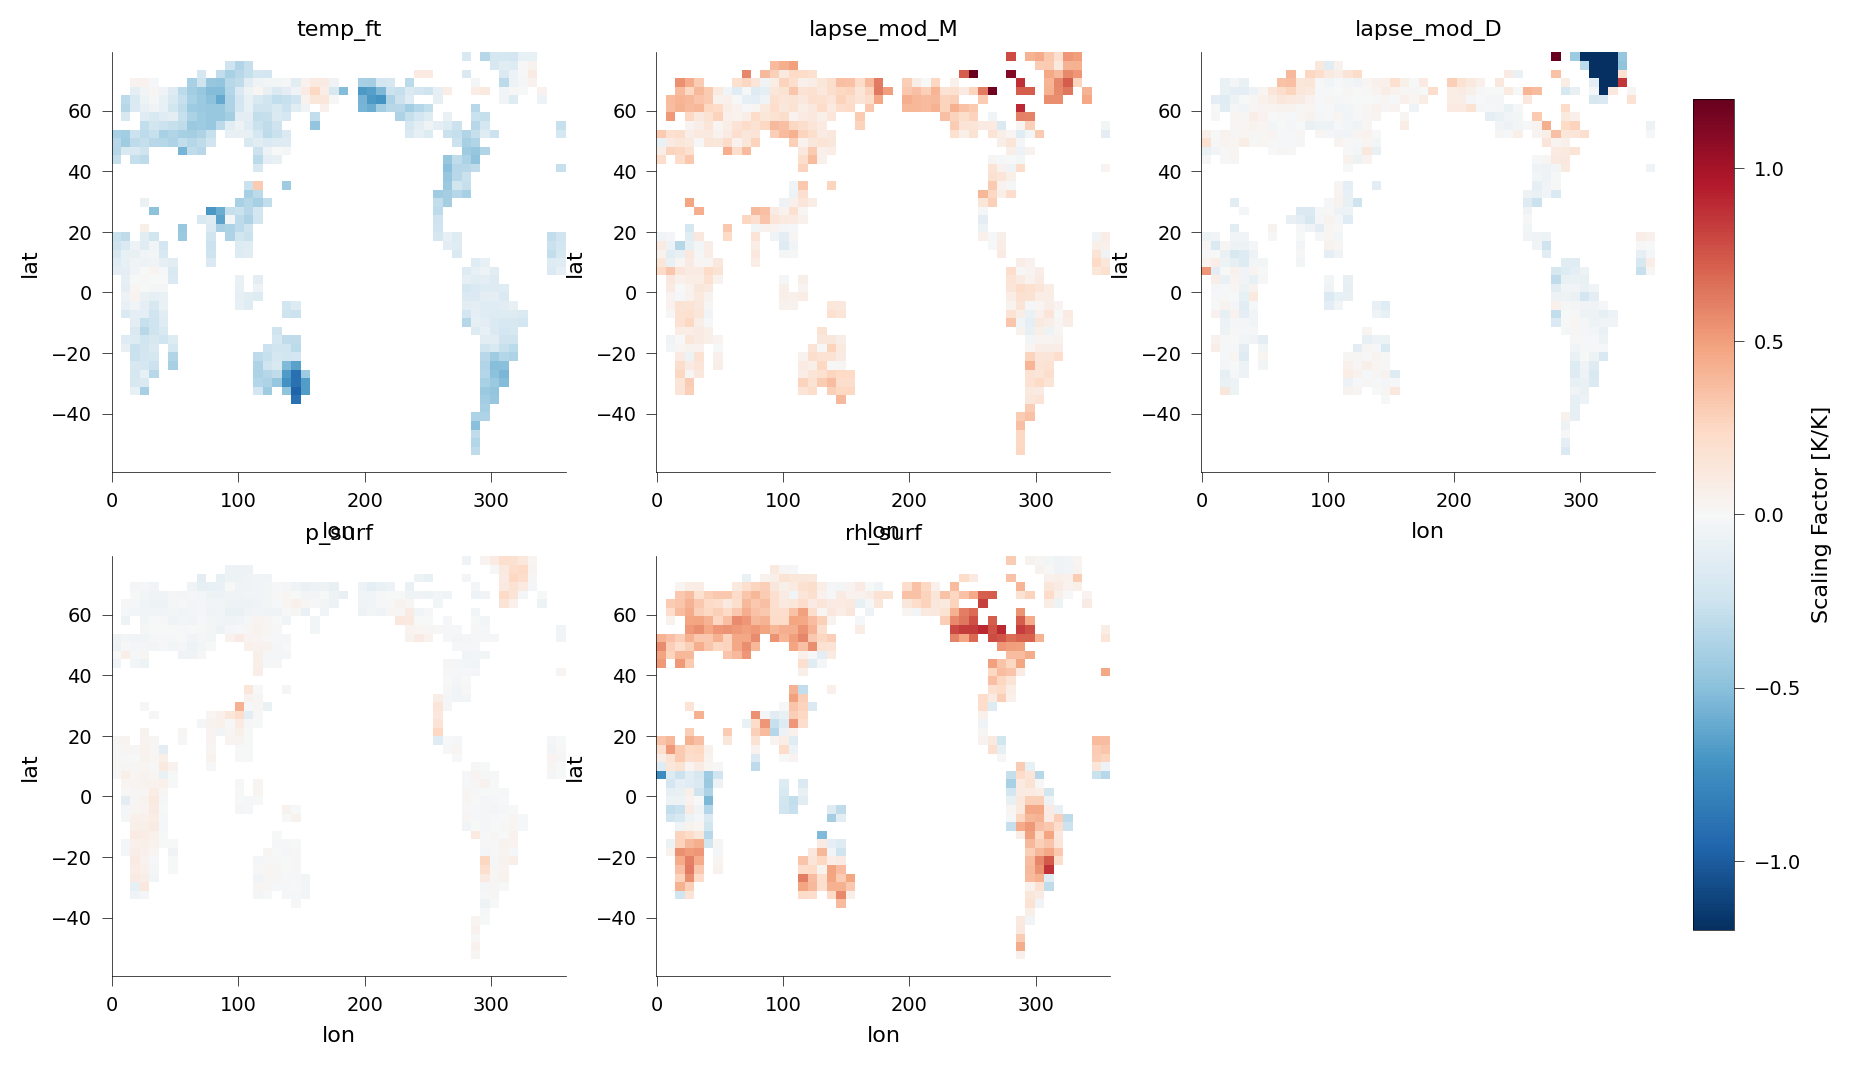

In [68]:
fig, ax = plt.subplots(2, 3)
ax = ax.flatten()
fig_resize(fig, 12)
for i, key in enumerate(sf_cont):
    if key == 'sum':
        continue
    im0 = (sf_cont[key]).plot(ax=ax[i], vmin=vmin_sf, add_colorbar=False)
    ax[i].set_title(key)
ax[-1].remove()

axes_for_cbar = [a for a in ax if a in fig.axes]
cbar = fig.colorbar(im0, ax=axes_for_cbar, orientation='vertical', shrink=0.9, pad=0.02)
cbar.set_label('Scaling Factor [K/K]')

plt.show()


### Physical Mechanisms 2
For the second version of the scale factor, I compute a separate scaling factor corresponding to the change with warming, and due to the anomaly in the current climate. These are dominated by the change mechanisms.
#### Change Mechanisms

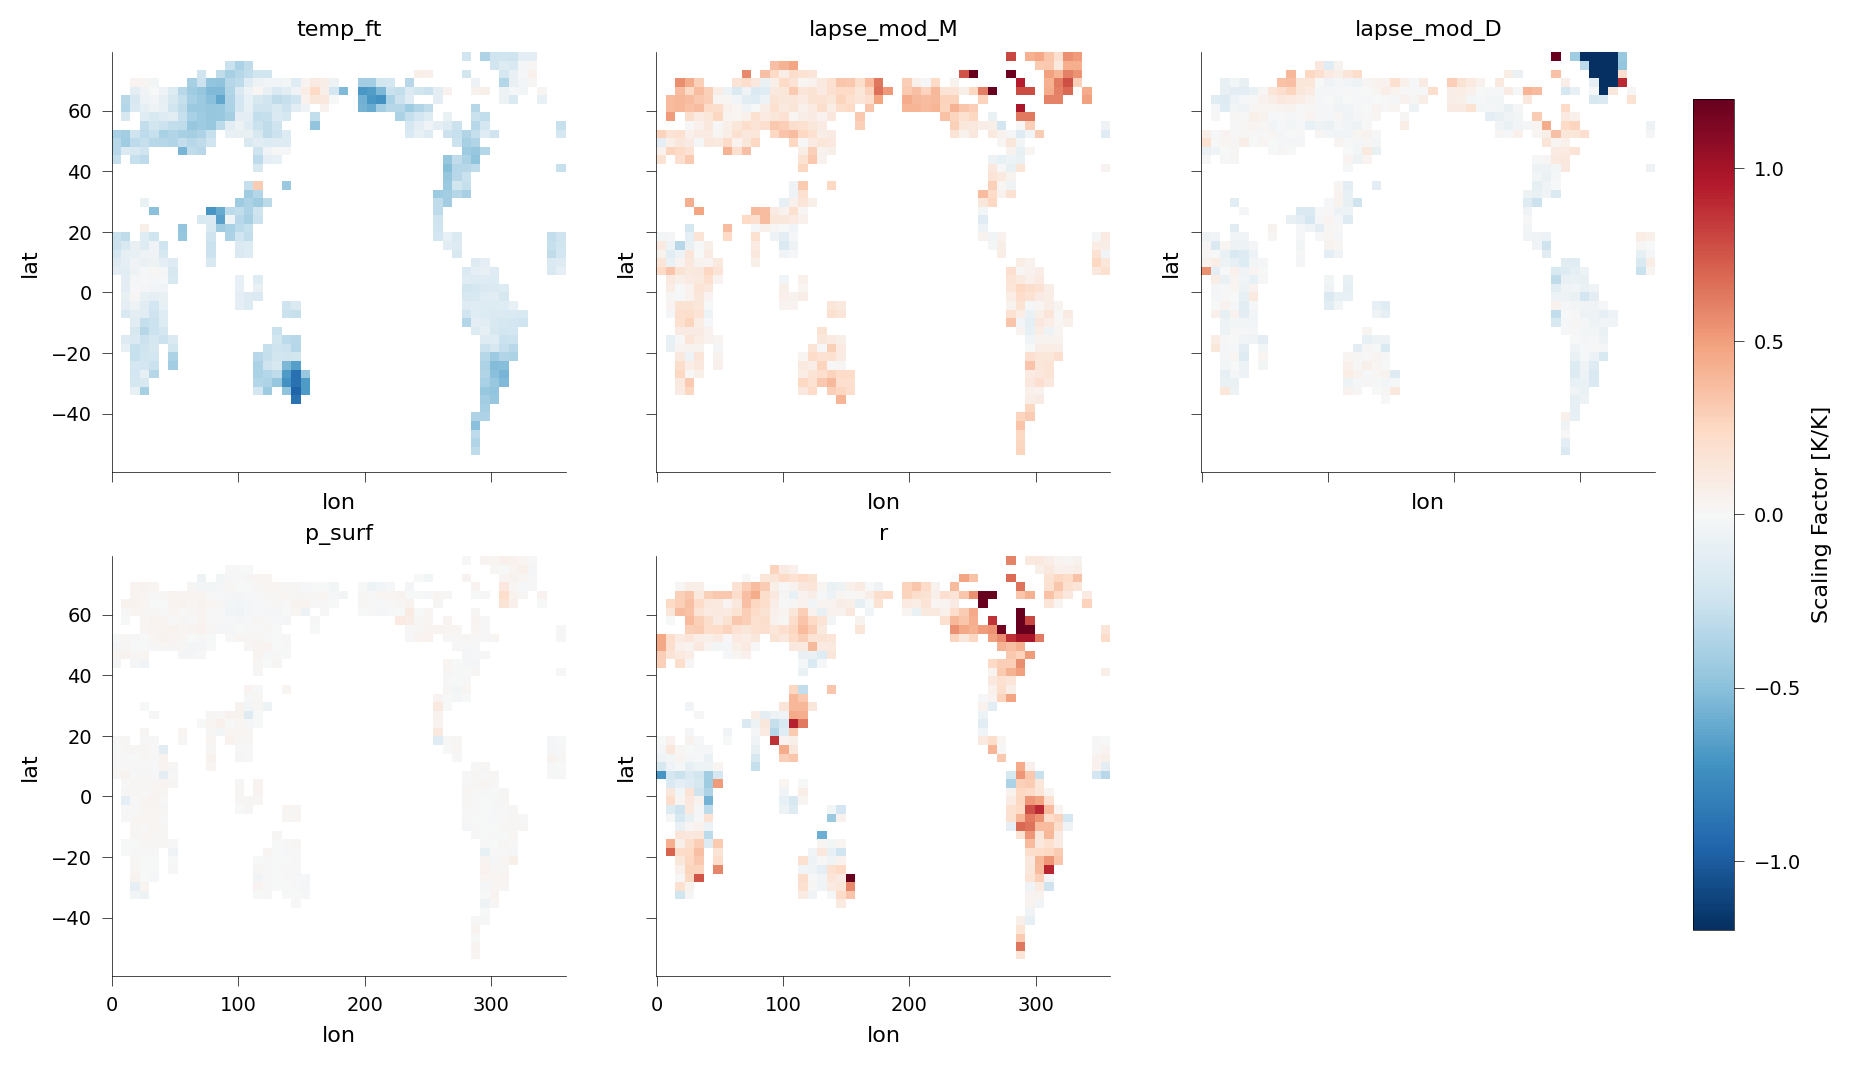

In [74]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
ax = ax.flatten()
fig_resize(fig, 12)
for i, key in enumerate(sf_cont):
    if key == 'sum':
        continue
    if 'rh' in key:
        key = 'r'
    im0 = (ds_use_sf[key+'_change']-1).plot(ax=ax[i], vmin=vmin_sf, add_colorbar=False)
    ax[i].set_title(key)
ax[-1].remove()

axes_for_cbar = [a for a in ax if a in fig.axes]
cbar = fig.colorbar(im0, ax=axes_for_cbar, orientation='vertical', shrink=0.9, pad=0.02)
cbar.set_label('Scaling Factor [K/K]')

plt.show()

#### Anom mechanisms

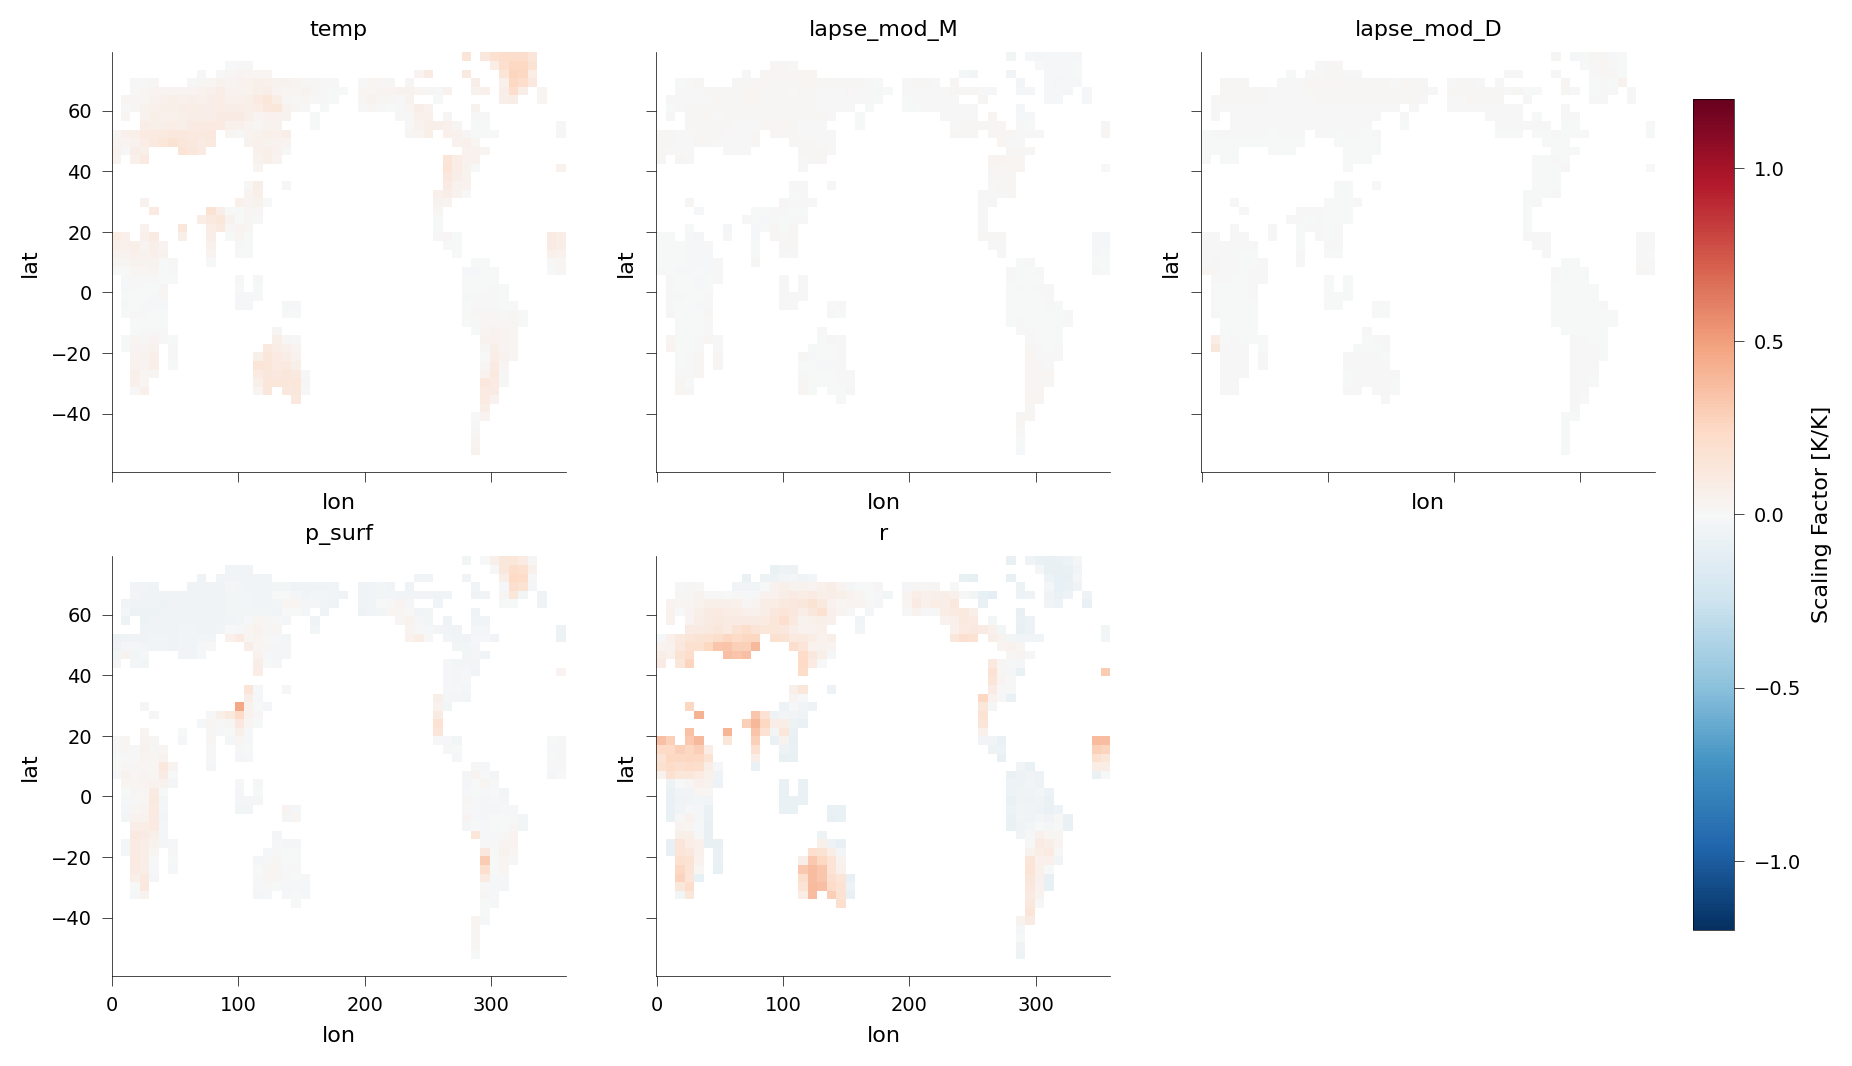

In [75]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
ax = ax.flatten()
fig_resize(fig, 12)
for i, key in enumerate(sf_cont):
    if key == 'sum':
        continue
    if 'rh' in key:
        key = 'r'
    if 'ft' in key:
        key = 'temp'
    im0 = (ds_use_sf[key+'_anom']-1).plot(ax=ax[i], vmin=vmin_sf, add_colorbar=False)
    ax[i].set_title(key)
ax[-1].remove()

axes_for_cbar = [a for a in ax if a in fig.axes]
cbar = fig.colorbar(im0, ax=axes_for_cbar, orientation='vertical', shrink=0.9, pad=0.02)
cbar.set_label('Scaling Factor [K/K]')

plt.show()

In [76]:
ds_use = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_quant/pre_industrial/REFHT_quant99/output.nc')